In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


##Import

In [2]:
from collections import OrderedDict
import numpy
import pandas

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

from rep.metaml import FoldingClassifier
from rep_ef.estimators import MatrixNetSkyGridClassifier

In [3]:
from utils import get_N_B_events, predict_by_estimator, bootstrap_calibrate_prob
from utils import get_events_number, get_events_statistics, result_table

## Reading initial data

In [4]:
import root_numpy
data_ele = pandas.DataFrame(root_numpy.root2array('datasets/old_tagging/nnet_ele.root'))
data_muon = pandas.DataFrame(root_numpy.root2array('datasets/old_tagging/nnet_muon.root'))
data_kaon = pandas.DataFrame(root_numpy.root2array('datasets/old_tagging/nnet_kaon.root'))
data_vtx = pandas.DataFrame(root_numpy.root2array('datasets/old_tagging/nnet_vtx.root'))

In [5]:
data_ele.columns

Index([u'iscorrect', u'tagAnswer', u'signVtx', u'tagger', u'evtNum', u'runNum', u'nnkrec', u'mult', u'ptB', u'etaB', u'partP', u'partPt', u'IPPU', u'PIDm', u'PIDe', u'PIDk', u'PIDpk', u'eOverP', u'veloch', u'PIDNNe', u'PIDNNm', u'PIDNNpi', u'PIDNNk', u'PIDNNp', u'IPs', u'IPssign', u'partlcs', u'partTheta', u'partPhi', u'ghostProb', u'nndr', u'nndeta', u'nndphi', u'nndq', u'vflag', u'ptmean', u'ipsmean', u'ipsmean2', u'ptsum', u'docamax', u'maxprobf', u'vratio', u'vcharge', u'svtau', u'svm', u'BDphiDir', u'svp', u'om_muon', u'om_ele', u'om_kaon', u'om_same', u'om_vtx', u'N_sig_sw'], dtype='object')

In [6]:
datasets = {'$e$': data_ele, '$\mu$': data_muon, '$K$': data_kaon, 'vtx': data_vtx}

In [7]:
for name, data in datasets.items():
    data['label'] = data.iscorrect
    # reconstructing sign of B using tagger answer and iscorrect (simulation fail)
    data['signB'] = data.tagAnswer * (2 * data.iscorrect - 1)
    data['event_id'] = data.runNum.apply(str) + '_' + data.evtNum.apply(str)

## Features used in training

In [8]:
features_vtx = ['mult', 'nnkrec', 'ptB', 'vflag', 'ipsmean', 'ptmean', 'vcharge', 
                'svm', 'svp', 'BDphiDir', 'svtau', 'docamax']

features_ele = ['mult', 'partPt', 'partP', 'ptB', 'IPs', 'partlcs', 'eOverP', 'ghostProb', 'IPPU']
features_muon = ['mult', 'partPt', 'partP', 'ptB', 'IPs', 'partlcs', 'PIDNNm', 'ghostProb', 'IPPU']
features_kaon = ['mult', 'partP', 'partPt', 'nnkrec', 'ptB', 'IPs', 'partlcs', 
                'PIDNNk', 'PIDNNpi', 'PIDNNp', 'ghostProb', 'IPPU']

features_tr = ['mult', 'partPt', 'partP', 'ptB', 'IPs', 'partlcs', 'ghostProb', 'IPPU', 'eOverP', 
               'PIDNNpi', 'PIDNNp', 'PIDNNk', 'PIDNNm', 'PIDNNe', 'nnkrec', 'partTheta', 'partPhi',
               'veloch']
                                    
features_tmva = {'$e$': features_ele, '$\mu$': features_muon,
                 '$K$': features_kaon, 'vtx': features_vtx}

features_xgb = {'$e$': features_tr, '$\mu$': features_tr,
                '$K$': features_tr, 'vtx': features_vtx}

In [9]:
get_N_B_events()

742867.7142562866

In [10]:
result = OrderedDict()

## Calculate $1 - \text{untag_efficiency}$ for each datasets

In [11]:
tagging_efficiecies = []
tagging_efficiecies_delta = []

for key, data in datasets.items():
    N_B_passed = get_events_number(data)
    tagging_efficiecies.append(1. * N_B_passed / get_N_B_events())
    tagging_efficiecies_delta.append(sqrt(N_B_passed) / get_N_B_events())
result['$\epsilon_{tag}$'] = tagging_efficiecies
result['$\Delta\epsilon_{tag}$'] = tagging_efficiecies_delta

In [12]:
tagging_efficiencies_table = pandas.DataFrame(result, index=datasets.keys())
tagging_efficiencies_table

,$\epsilon_{tag}$,$\Delta\epsilon_{tag}$
vtx,0.181978,0.000495
$K$,0.170796,0.000479
$e$,0.016424,0.000149
$\mu$,0.054385,0.000271


### Define B-like events for training and others for prediction
using the threshold on sweight for splitting

In [13]:
sweight_threshold = 0.

data_sw_passed = dict([(key, data[data.N_sig_sw > sweight_threshold]) for key, data in datasets.items()])
data_sw_not_passed = dict([(key, data[data.N_sig_sw <= sweight_threshold]) for key, data in datasets.items()])

In [14]:
for key, data in data_sw_passed.items():
    print key, get_events_statistics(data)

vtx {'tracks': 157236, 'Events': 157236}
$K$ {'tracks': 143163, 'Events': 143163}
$e$ {'tracks': 13324, 'Events': 13324}
$\mu$ {'tracks': 45398, 'Events': 45398}


In [15]:
for key, data in data_sw_not_passed.items():
    print key, get_events_statistics(data)

vtx {'tracks': 44195, 'Events': 44194}
$K$ {'tracks': 33409, 'Events': 33408}
$e$ {'tracks': 2305, 'Events': 2305}
$\mu$ {'tracks': 10236, 'Events': 10236}


In [16]:
estimators = OrderedDict()

### TMVA

In [17]:
from rep.estimators import TMVAClassifier

In [18]:
from rep.estimators import TMVAClassifier
from rep.metaml import FoldingClassifier

tmva_base_muon = TMVAClassifier(method='kMLP', factory_options='Transformations=I', sigmoid_function='identity',
                                NeuronType='tanh', NCycles=280, HiddenLayers='N+5', TrainingMethod='BFGS', TestRate=5,
                                UseRegulator=True, EstimatorType='CE')

tmva_base_ele = TMVAClassifier(method='kMLP', factory_options='Transformations=I', sigmoid_function='identity',
                               NeuronType='sigmoid', NCycles=180, HiddenLayers='N+5', TrainingMethod='BFGS', 
                               UseRegulator=True)

tmva_base_kaon_vtx = TMVAClassifier(method='kMLP', factory_options='Transformations=I', 
                                    sigmoid_function='identity',
                                    NeuronType='tanh', NCycles=180, HiddenLayers='N+5', TrainingMethod='BFGS', 
                                    UseRegulator=True, EstimatorType='CE')


for key, data in data_sw_passed.items():
    if 'e' in key:
        tmva_base = tmva_base_ele
    elif 'mu' in key:
        tmva_base = tmva_base_muon
    else:
        tmva_base = tmva_base_kaon_vtx
    estimators[key + '_tmva'] = FoldingClassifier(tmva_base, n_folds=2, random_state=11, ipc_profile='ssh-ipy',
                                                  features=features_tmva[key])
    estimators[key + '_tmva'].fit(data, data['label'], data['N_sig_sw'])

### XGBoost

In [19]:
from rep.estimators import XGBoostClassifier
from rep.metaml import FoldingClassifier

xgb_base_ele = XGBoostClassifier(colsample=1.0, eta=0.01, nthreads=4, 
                                 n_estimators=200, subsample=0.3, max_depth=5) 

xgb_base_other = XGBoostClassifier(colsample=1.0, eta=0.01, nthreads=4, 
                                   n_estimators=500, subsample=0.3, max_depth=3) 

for key, data in data_sw_passed.items():
    if 'e' in key:
        xgb_base = xgb_base_ele
    else:
        xgb_base = xgb_base_other
        
    estimators[key + '_xgboost'] = FoldingClassifier(xgb_base, n_folds=2, random_state=11, ipc_profile='ssh-ipy',
                                                     features=features_xgb[key])
    estimators[key + '_xgboost'].fit(data, data['label'], data['N_sig_sw'])

In [20]:
import cPickle
with open('models/old-tagging.pkl', 'w') as f:
    cPickle.dump(estimators, f)

In [21]:
for key, _ in datasets.items():
    for suffix in ['_xgboost', '_tmva']:
        name = key + suffix
        probs = estimators[name].predict_proba(data_sw_passed[key])[:, 1]
        print name, 'AUC:', roc_auc_score(data_sw_passed[key]['label'].values, 
                                          probs, sample_weight=data_sw_passed[key]['N_sig_sw'].values)

KFold prediction using folds column
vtx_xgboost AUC: 0.568958759308
KFold prediction using folds column
vtx_tmva AUC: 0.546857893467
KFold prediction using folds column
$K$_xgboost AUC: 0.566317558289
KFold prediction using folds column
$K$_tmva AUC: 0.545140028
KFold prediction using folds column
$e$_xgboost AUC: 0.588713169098
KFold prediction using folds column
$e$_tmva AUC: 0.578032553196
KFold prediction using folds column
$\mu$_xgboost AUC: 0.616870701313
KFold prediction using folds column
$\mu$_tmva AUC: 0.60550391674


--------

## Calculate quality for each tagger (ele, muon, kaon, vtx)

using isotonic calibration with bootstrap

In [22]:
models = []

In [23]:
for key, _ in datasets.items():
    for suffix in ['_xgboost', '_tmva']:
        name = key +  suffix
        data_predicted, probs = predict_by_estimator(estimators[name], [data_sw_passed[key], data_sw_not_passed[key]])
        D2, aucs = bootstrap_calibrate_prob(data_predicted.label.values, data_predicted.N_sig_sw.values,
                                            probs, n_calibrations=30)
        print name, 'AUC:', numpy.mean(aucs), 'AUC delta', numpy.std(aucs)
        tagging_efficiency, tagging_efficiency_delta = \
            numpy.array(tagging_efficiencies_table[tagging_efficiencies_table.index == key])[0]
        models.append(result_table(tagging_efficiency, tagging_efficiency_delta, D2, 0., name))

KFold prediction using folds column
KFold prediction using folds column
vtx_xgboost AUC: 0.571984686454 AUC delta 0.00194738399544
KFold prediction using folds column
KFold prediction using folds column
vtx_tmva AUC: 0.549553102255 AUC delta 0.00180471154176
KFold prediction using folds column
KFold prediction using folds column
$K$_xgboost AUC: 0.567998558283 AUC delta 0.00130036192652
KFold prediction using folds column
KFold prediction using folds column
$K$_tmva AUC: 0.54444070061 AUC delta 0.00201123697597
KFold prediction using folds column
KFold prediction using folds column
$e$_xgboost AUC: 0.589169506232 AUC delta 0.0052482638659
KFold prediction using folds column
KFold prediction using folds column
$e$_tmva AUC: 0.578294150035 AUC delta 0.00604454670907
KFold prediction using folds column
KFold prediction using folds column
$\mu$_xgboost AUC: 0.622159639994 AUC delta 0.0035700769756
KFold prediction using folds column
KFold prediction using folds column
$\mu$_tmva AUC: 0.606

In [24]:
pandas.concat(models)

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,vtx_xgboost,18.197761,0.049494,0.051041,0.001204,0.928835,0.022048,0,0
0,vtx_tmva,18.197761,0.049494,0.041750,0.001080,0.759760,0.019759,0,0
0,$K$_xgboost,17.079611,0.047949,0.055012,0.001113,0.939581,0.019186,0,0
0,$K$_tmva,17.079611,0.047949,0.047596,0.001197,0.812917,0.020575,0,0
0,$e$_xgboost,1.642418,0.014869,0.177646,0.006891,0.291768,0.011621,0,0
0,$e$_tmva,1.642418,0.014869,0.172428,0.006744,0.283198,0.011369,0,0
0,$\mu$_xgboost,5.438510,0.027057,0.170483,0.003694,0.927175,0.020614,0,0
0,$\mu$_tmva,5.438510,0.027057,0.165106,0.004528,0.897930,0.025030,0,0


---------------------

# Combination of all taggers

In [25]:
from utils import predict_by_estimator, bootstrap_calibrate_prob, calculate_auc_with_and_without_untag_events
from utils import calibrate_probs

In [26]:
def combine_taggers(tagger_outputs, tagger_keys):
    """
    Copy-pasted formulas (5.1), (5.2) from [TODO link].
    Formulas by themselves are not readable, please refer to context.
    
    :param tagger_outputs: output of tagger for tracks. 
     There are 4 taggers, each having 
     tag_n - tagger output. 
     prob_n - probability of right tagged.
    """
    pb = []
    pnb = []
    for key in tagger_keys:
        prob = tagger_outputs['prob_{}'.format(key)].values
        tag = tagger_outputs['tag_{}'.format(key)].values
        pb.append((1 + tag) / 2 - tag * prob)
        pnb.append((1 - tag) / 2 + tag * prob)
    pb = numpy.prod(pb, axis=0)
    pnb = numpy.prod(pnb, axis=0)
    probs_wrong = pb / (pb + pnb)
    tag_result = numpy.ones(len(probs_wrong))
    tag_result[probs_wrong > 0.5] = -1
    return tag_result, 1 - probs_wrong, tagger_outputs.weight.values, tagger_outputs.signB.values

In [27]:
def run_combine(model_suffix="", model_name="", logistic=False):
    """
    :param suffix: suffix used for taggers
    :param model_name: name for model after combining classifiers
    """
    data_with_predictions = {}
    # computing calibrated predictions of each tagger
    for key in datasets.keys():
        name = key + model_suffix
        data, probs = predict_by_estimator(estimators[name], [data_sw_passed[key], data_sw_not_passed[key]])
        probs_calibrated = calibrate_probs(data.label.values, data.N_sig_sw.values, probs, logistic=logistic)
            
        ids = numpy.array(data['event_id'])
        data_with_predictions[key] = pandas.DataFrame({'prob_{}'.format(key): probs_calibrated, 
                                                       'tag_{}'.format(key): data.tagAnswer.values,
                                                       'weight': data.N_sig_sw.values,
                                                       'signB': data.signB.values}, index=ids)
    # collecting all together, 
    # setting tag_n = -99 if untagged
    data_combined = pandas.DataFrame({'event_id': numpy.unique(numpy.concatenate([d.index.values for d in 
                                                                                 data_with_predictions.values()]))})
    data_combined.index = data_combined.event_id
    tagger_keys = datasets.keys()
    for key in tagger_keys:
        data_combined['prob_{}'.format(key)] = 0.5
        data_combined['tag_{}'.format(key)] = 1
    for key, d in data_with_predictions.items():
        data_combined.ix[d.index, 'prob_{}'.format(key)] = d['prob_{}'.format(key)]
        data_combined.ix[d.index, 'tag_{}'.format(key)] = d['tag_{}'.format(key)]
        data_combined.ix[d.index, 'weight'] = d['weight']
        data_combined.ix[d.index, 'signB'] = d['signB']
    
    # getting predictions
    tags, Bprobs, Bweights, Bsign = combine_taggers(data_combined, tagger_keys)

    auc, auc_full = calculate_auc_with_and_without_untag_events(Bsign, Bprobs, Bweights)
    print 'AUC for tagged:', auc, 'AUC with untag:', auc_full
    
    hist(Bprobs[Bsign == 1], alpha=0.4, bins=70, weights=Bweights[Bsign == 1], label='$B^+$')
    hist(Bprobs[Bsign == -1], alpha=0.4, bins=70, weights=Bweights[Bsign == -1], label='$B^-$')
    legend(), title('B probs'), show()
    
    fpr, tpr, _ = roc_curve(Bsign, Bprobs, sample_weight=Bweights)
    plot(fpr, tpr), plot([0, 1], [0, 1]), show()

    tagging_efficiency_combined = sum(Bweights) / get_N_B_events()
    tagging_efficiency_combined_delta = numpy.sqrt(sum(Bweights)) / get_N_B_events()
    
    D2, aucs = bootstrap_calibrate_prob(Bsign, Bweights, Bprobs)
    print 'Average AUC', numpy.mean(aucs), numpy.std(aucs)
    
    return result_table(tagging_efficiency_combined, tagging_efficiency_combined_delta, D2, auc_full, model_name)

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
AUC for tagged: 0.659639946039 AUC with untag: 0.566958915922


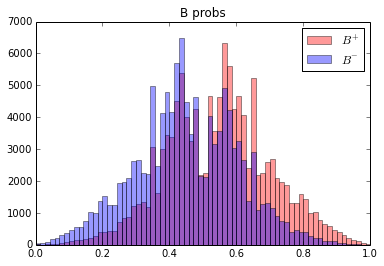

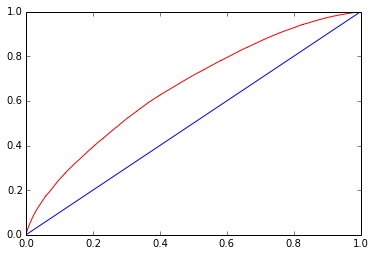

Average AUC 0.659859421181 0.00112034944951
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
AUC for tagged: 0.653980885649 AUC with untag: 0.565845722383


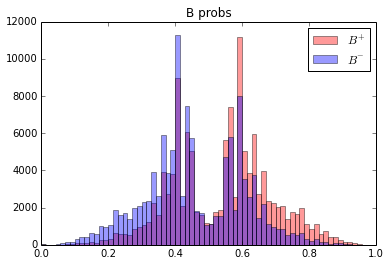

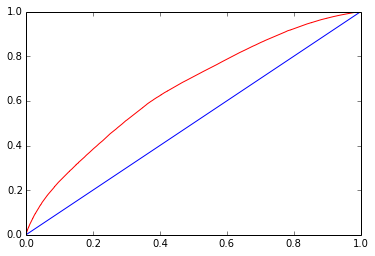

Average AUC 0.654287174435 0.000829235452093
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
AUC for tagged: 0.659818032966 AUC with untag: 0.566731910257


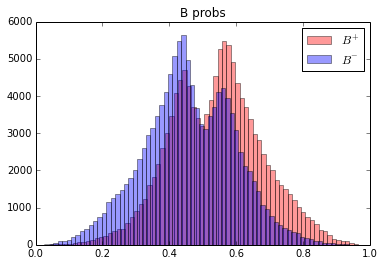

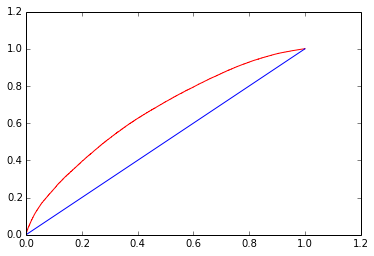

Average AUC 0.659911124536 0.00115539615541


In [28]:
results = [run_combine("_xgboost", "iso-xgb_combined"), 
           run_combine("_tmva", "iso-tmva_combined"),
           run_combine("_xgboost", "log-xgb_combined", logistic=True)]

KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
AUC for tagged: 0.653946397447 AUC with untag: 0.565877531634


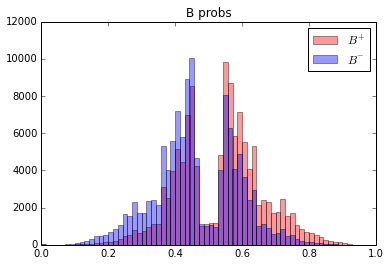

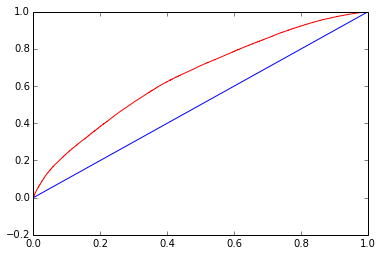

Average AUC 0.653961198272 0.0013066507299


In [29]:
results.append(run_combine("_tmva", "log-tmva_combined", logistic=True))

In [30]:
pandas.concat(results)

,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,iso-xgb_combined,32.734997,0.066382,0.070254,0.001431,2.299776,0.047059,56.695892,0
0,iso-tmva_combined,32.734997,0.066382,0.067655,0.002165,2.214680,0.071023,56.584572,0
0,log-xgb_combined,32.734997,0.066382,0.074060,0.001004,2.424358,0.033222,56.673191,0
0,log-tmva_combined,32.734997,0.066382,0.068125,0.000907,2.230081,0.030019,56.587753,0
